In [56]:
import h5py
import numpy as np
import pandas as pd

In [57]:
example_path = r"c:\Users\dhers\OneDrive - UBA\SLEAP\EPM\labels.v001.005_WIN_20240405_14_26_38_Pro_aligned.h5"

In [58]:
with h5py.File(example_path, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(example_path)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===filename===
c:\Users\dhers\OneDrive - UBA\SLEAP\EPM\labels.v001.005_WIN_20240405_14_26_38_Pro_aligned.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(9000, 9, 2, 1)

===nodes===
0: nose
1: head
2: neck
3: left_ear
4: right_ear
5: body
6: tail_1
7: tail_2
8: tail_3



In [59]:
data = locations

# Step 1: Remove the mouse identity dimension (last dimension)
squeezed_data = np.squeeze(data, axis=-1)  # New shape: (9000, 9, 2)

# Reshape the data to (9000, 18) where each row is a frame
flattened_data = data.reshape(9000, -1)

#  Step 2: Separate X and Y coordinates
columns = []
for name in node_names:
    columns.extend([f"{name}_x", f"{name}_y"])

# Step 3: Create DataFrame
df = pd.DataFrame(flattened_data, columns=columns)

# Verify the DataFrame
print(df.head())

       nose_x      nose_y    head_x      head_y     neck_x      neck_y  \
0         NaN         NaN       NaN         NaN        NaN         NaN   
1         NaN         NaN       NaN         NaN        NaN         NaN   
2         NaN         NaN       NaN         NaN        NaN         NaN   
3         NaN         NaN       NaN         NaN        NaN         NaN   
4  343.287537  592.704834  344.5961  592.348755  356.17334  587.917297   

   left_ear_x  left_ear_y  right_ear_x  right_ear_y      body_x     body_y  \
0         NaN         NaN          NaN          NaN         NaN        NaN   
1         NaN         NaN          NaN          NaN         NaN        NaN   
2         NaN         NaN          NaN          NaN         NaN        NaN   
3         NaN         NaN          NaN          NaN         NaN        NaN   
4   347.71579  584.683838   355.930115   595.981873  372.439392  563.88446   

     tail_1_x    tail_1_y    tail_2_x    tail_2_y    tail_3_x    tail_3_y  
0         

In [60]:
def open_h5_file(path, software: str = "DLC", print_data: bool = False, num_sd: float = 2) -> pd.DataFrame:
    """Opens an h5 file and returns the data as a pandas dataframe.

    Args:
        path (str): Path to the h5 file.
        software (str, optional): Software used to generate the h5 file. Defaults to "DLC".
        print_data (bool, optional): Whether to print the data. Defaults to False.
        num_sd (float, optional): Number of std_dev away from the mean. Defaults to 2.
        
    Returns:
        DataFrame with columns [x, y, likelihood] for each body part
    """

    if software == "DLC":
        df = pd.read_hdf(path)
        scorer = df.columns.levels[0][0]
        bodyparts = df.columns.levels[1].to_list()
        df = df[scorer]

        df_raw = pd.DataFrame()

        for key in df.keys():
            df_raw[str(key[0]) + "_" + str(key[1])] = df[key]

    elif software == "SLEAP":
        with h5py.File(path, "r") as f:
            scorer = "SLEAP"
            locations = f["tracks"][:].T
            bodyparts = [n.decode() for n in f["node_names"][:]]

        # Remove singleton dimension and reshape
        squeezed_data = np.squeeze(locations, axis=-1)
        flattened_data = squeezed_data.reshape(squeezed_data.shape[0], -1)

        # Create base DataFrame with x/y columns
        base_columns = [f"{name}_{coord}" for name in bodyparts for coord in ["x", "y"]]
        df = pd.DataFrame(flattened_data, columns=base_columns)

        # Add likelihood columns
        for name in bodyparts:
            x_col = f"{name}_x"
            y_col = f"{name}_y"
            likelihood_col = f"{name}_likelihood"
            
            # Calculate likelihood (0 if any coordinate is NaN, else 1)
            df[likelihood_col] = (~df[x_col].isna() & ~df[y_col].isna()).astype(int)

        # Reorder columns to include likelihood after coordinates
        ordered_columns = []
        for name in bodyparts:
            ordered_columns.extend([f"{name}_x", f"{name}_y", f"{name}_likelihood"])
            
        df_raw = df[ordered_columns]

    else:
        raise ValueError(f"Invalid software: {software}")
    
    if print_data:
        print(f"Positions obtained by: {scorer}")
        print(f"Points in df: {bodyparts}")
        print(f"Frame count: {df_raw.shape[0]}")
        for point in bodyparts:
            median = df_raw[f'{point}_likelihood'].median()
            mean = df_raw[f'{point}_likelihood'].mean()
            std_dev = df_raw[f'{point}_likelihood'].std()
            print(f'{point} \t median: {median:.2f} \t mean: {mean:.2f} \t std_dev: {std_dev:.2f} \t tolerance: {mean - num_sd*std_dev:.2f}')

    return df_raw

In [61]:
# Assuming your data is stored in a variable called 'locations'
df_raw = open_h5_file(example_path, software = "SLEAP", print_data=True)

Positions obtained by: SLEAP
Points in df: ['nose', 'head', 'neck', 'left_ear', 'right_ear', 'body', 'tail_1', 'tail_2', 'tail_3']
Frame count: 9000
nose 	 median: 1.00 	 mean: 0.97 	 std_dev: 0.16 	 tolerance: 0.64
head 	 median: 1.00 	 mean: 0.97 	 std_dev: 0.17 	 tolerance: 0.62
neck 	 median: 1.00 	 mean: 0.99 	 std_dev: 0.11 	 tolerance: 0.78
left_ear 	 median: 1.00 	 mean: 0.99 	 std_dev: 0.10 	 tolerance: 0.79
right_ear 	 median: 1.00 	 mean: 0.96 	 std_dev: 0.19 	 tolerance: 0.59
body 	 median: 1.00 	 mean: 0.99 	 std_dev: 0.08 	 tolerance: 0.83
tail_1 	 median: 1.00 	 mean: 0.99 	 std_dev: 0.11 	 tolerance: 0.77
tail_2 	 median: 1.00 	 mean: 0.92 	 std_dev: 0.26 	 tolerance: 0.40
tail_3 	 median: 1.00 	 mean: 0.89 	 std_dev: 0.32 	 tolerance: 0.25


In [62]:
from scipy import signal

def filter_and_smooth_df(data: pd.DataFrame, bodyparts: list = [], objects: list = [], med_filt_window: int = 3, drop_below: float = 0.5, num_sd: float = 2) -> pd.DataFrame:
    """Filters and smooths a DataFrame of coordinates.

    Args:
        data (pd.DataFrame): DataFrame of coordinates.
        bodyparts (list): List of bodyparts to filter. Defaults to [] (empty list means include all).
        objects (list): List of objects to filter. Defaults to [].
        med_filt_window (int, optional): Window size for median filtering. Defaults to 3.
        drop_below (float, optional): Minimum likelihood to keep a bodypart. Defaults to 0.1.
        num_sd (float, optional): Number of standard deviations to use as the threshold. Defaults to 2.

    Returns:
        pd.DataFrame: Filtered and smoothed DataFrame of coordinates.
    """
    df = data.copy()

    if not bodyparts:
        # Remove suffixes (_x, _y, _likelihood) and get unique body parts
        columns = set(col.rsplit('_', 1)[0] for col in df.columns)
        
        # Filter out body parts that are in the objects list
        bodyparts = [bp for bp in columns if bp not in objects]
    
    # Try different filtering parameters
    sigma, n_sigmas = 0.6, 2
    N = int(2 * n_sigmas * sigma + 1)

    # Gaussian kernel
    gauss_kernel = signal.windows.gaussian(N, sigma)
    gauss_kernel = gauss_kernel / sum(gauss_kernel)
    pad_width = (len(gauss_kernel) - 1) // 2

    for point in bodyparts:

        median = df[f'{point}_likelihood'].median()
        mean = df[f'{point}_likelihood'].mean()
        std_dev = df[f'{point}_likelihood'].std()
            
        limit = mean - num_sd*std_dev

        # Set x and y coordinates to NaN where the likelihood is below the tolerance limit
        df.loc[df[f'{point}_likelihood'] < limit, [f'{point}_x', f'{point}_y']] = np.nan
        
        for axis in ['x','y']:
            column = f'{point}_{axis}'

            # Interpolate using the pchip method
            df[column] = df[column].interpolate(method='pchip', limit_area='inside')
            
            # Forward fill the remaining NaN values
            df[column] = df[column].ffill() #.bfill()
            
            # Apply median filter
            df[column] = signal.medfilt(df[column], kernel_size = med_filt_window)
            
            # Pad the median filtered data to mitigate edge effects
            padded = np.pad(df[column], pad_width, mode='edge')
            
            # Apply convolution
            smooth = signal.convolve(padded, gauss_kernel, mode='valid')
            
            # Trim the padded edges to restore original length
            df[column] = smooth[:len(df[column])]

    for obj in objects:

        median = df[f'{obj}_likelihood'].median()
        mean = df[f'{obj}_likelihood'].mean()
        std_dev = df[f'{obj}_likelihood'].std()
            
        limit = mean - num_sd*std_dev
        
        if median < drop_below:
            # If the likelihood of an object is too low, probably the object is not there. Lets drop those columns
            df.drop([f'{obj}_x', f'{obj}_y', f'{obj}_likelihood'], axis=1, inplace=True)
        
        else:
            # Set x and y coordinates to NaN where the likelihood is below the tolerance limit
            df.loc[df[f'{obj}_likelihood'] < limit, [f'{obj}_x', f'{obj}_y']] = np.nan
            
            for axis in ['x','y']:
                column = f'{obj}_{axis}'
                df[column] = df[column].median()

    return df

In [63]:
df_smooth = filter_and_smooth_df(df_raw)

In [64]:
df_smooth

,nose_x,nose_y,nose_likelihood,head_x,head_y,head_likelihood,neck_x,neck_y,neck_likelihood,left_ear_x,...,body_likelihood,tail_1_x,tail_1_y,tail_1_likelihood,tail_2_x,tail_2_y,tail_2_likelihood,tail_3_x,tail_3_y,tail_3_likelihood
0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
1,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
2,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
3,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
4,364.830654,592.374601,1,366.184345,591.885919,1,373.470116,587.093041,1,358.959485,...,1,387.038109,526.863162,1,330.403907,606.522686,1,295.038337,622.770530,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,836.307785,437.296164,1,824.654017,440.816797,1,813.085040,441.903951,1,817.077168,...,1,743.816400,453.864007,1,705.492349,452.689359,1,674.458845,448.135759,1
8996,836.252674,437.250675,1,824.566007,440.802669,1,813.571394,441.920036,1,817.546966,...,1,744.341656,455.889442,1,707.397607,455.756647,1,675.099696,451.601781,1
8997,836.015439,437.244704,1,824.465796,440.807450,1,815.450763,443.848117,1,819.363069,...,1,744.291126,455.856281,1,707.836534,456.324282,1,677.213872,452.551175,1
8998,835.511704,437.248430,1,824.443100,440.813128,1,815.446315,444.336374,1,819.365790,...,1,743.625115,453.702524,1,707.255563,455.569806,1,677.189714,452.440842,1


In [65]:
import plotly.graph_objects as go

def plot_raw_vs_smoothed(df_raw, df_smooth, bodypart = 'nose', num_sd = 2):

    # Create figure
    fig = go.Figure()

    # Add traces for raw data
    for column in df_raw.columns:
        if bodypart in column:
            if 'likelihood' not in column:
                fig.add_trace(go.Scatter(x=df_raw.index, y=df_raw[column], mode='markers', name=f'raw {column}', marker=dict(symbol='x', size=6)))
            elif '_y' not in column:
                fig.add_trace(go.Scatter(x=df_raw.index, y=df_raw[column], name=f'{column}', line=dict(color='black', width=3), yaxis='y2',opacity=0.5))

    # Add traces for smoothed data
    for column in df_smooth.columns:
        if bodypart in column:
            if 'likelihood' not in column:
                fig.add_trace(go.Scatter(x=df_smooth.index, y=df_smooth[column], name=f'new {column}', line=dict(width=3)))

    median = df_raw[f'{bodypart}_likelihood'].median()
    mean = df_raw[f'{bodypart}_likelihood'].mean()
    std_dev = df_raw[f'{bodypart}_likelihood'].std()
        
    limit = mean - num_sd*std_dev

    # Update layout for secondary y-axis
    fig.update_layout(
        xaxis=dict(title='Video frame'),
        yaxis=dict(title=f'{bodypart} position (pixels)'),
        yaxis2=dict(title=f'{bodypart} likelihood', 
                    overlaying='y', 
                    side='right',
                    gridcolor='black'),
        title=f'{bodypart} position & likelihood',
        legend=dict(yanchor="bottom",
                    y=1,
                    xanchor="center",
                    x=0.5,
                    orientation="h"),
        shapes=[dict(type='line', 
                    x0=df_raw.index.min(), 
                    x1=df_raw.index.max(), 
                    y0=limit, 
                    y1=limit, 
                    line=dict(color='black', dash='dash'),
                    yref='y2')],
    )

    # Show plot
    fig.show()

In [73]:
plot_raw_vs_smoothed(df_raw, df_smooth, bodypart = 'nose', num_sd = 2)

In [ ]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("nodes:", node_names)
print("instance count:", instance_count)

frame count: 9000
node count: 9
instance count: 1


In [25]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [26]:
locations = fill_missing(locations)

In [27]:
NOSE_INDEX = 0
BODY_INDEX = 5

nose_loc = locations[:, NOSE_INDEX, :, :]
body_loc = locations[:, BODY_INDEX, :, :]

In [28]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [29]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

Text(0.5, 1.0, 'Body & Nose tracks')

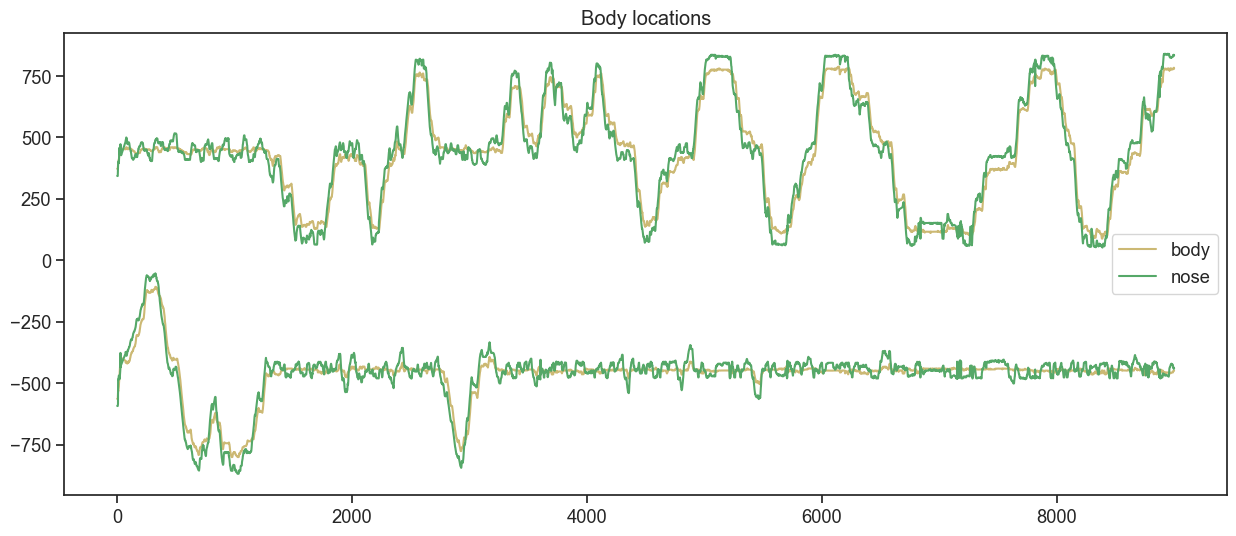

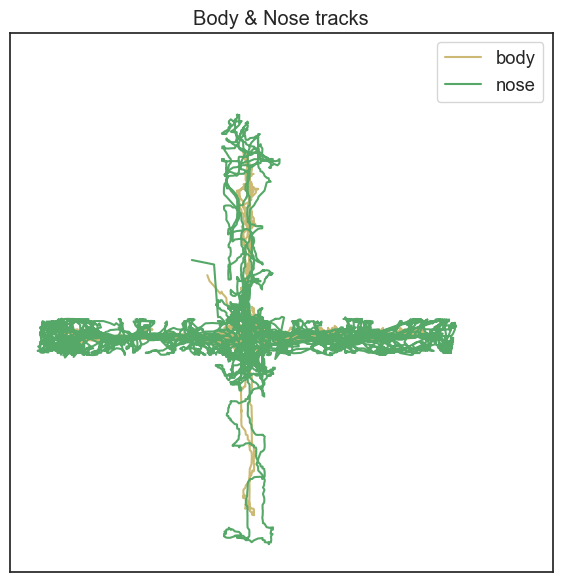

In [33]:
plt.figure()
plt.plot(body_loc[:,0,0], 'y',label='body')
plt.plot(nose_loc[:,0,0], 'g',label='nose')

plt.plot(-1*body_loc[:,1,0], 'y')
plt.plot(-1*nose_loc[:,1,0], 'g')

plt.legend(loc="center right")
plt.title('Body locations')

plt.figure(figsize=(7,7))
plt.plot(body_loc[:,0,0],body_loc[:,1,0], 'y',label='body')
plt.plot(nose_loc[:,0,0],nose_loc[:,1,0], 'g',label='nose')
plt.legend()

plt.xlim(0,1024)
plt.xticks([])

plt.ylim(0,1024)
plt.yticks([])
plt.title('Body & Nose tracks')

In [34]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

In [37]:
body_vel = smooth_diff(body_loc[:, :, 0])

Text(0.5, 1.0, 'Velocity')

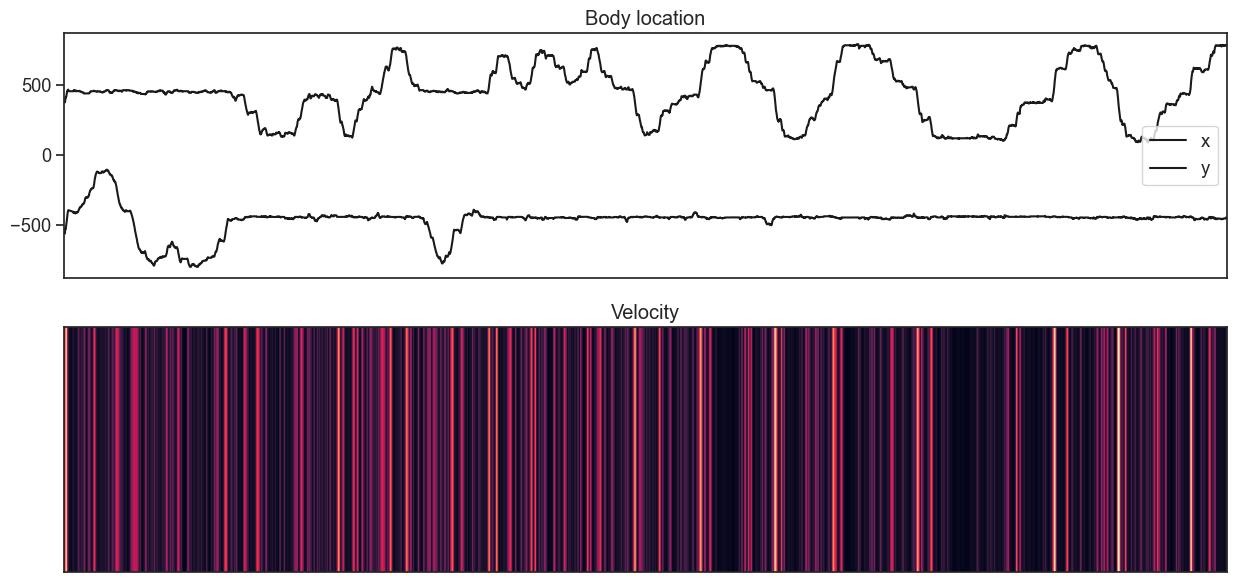

In [38]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(body_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*body_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Body location')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.imshow(body_vel[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

Text(0.5, 1.0, 'Body tracks colored by magnitude of fly speed')

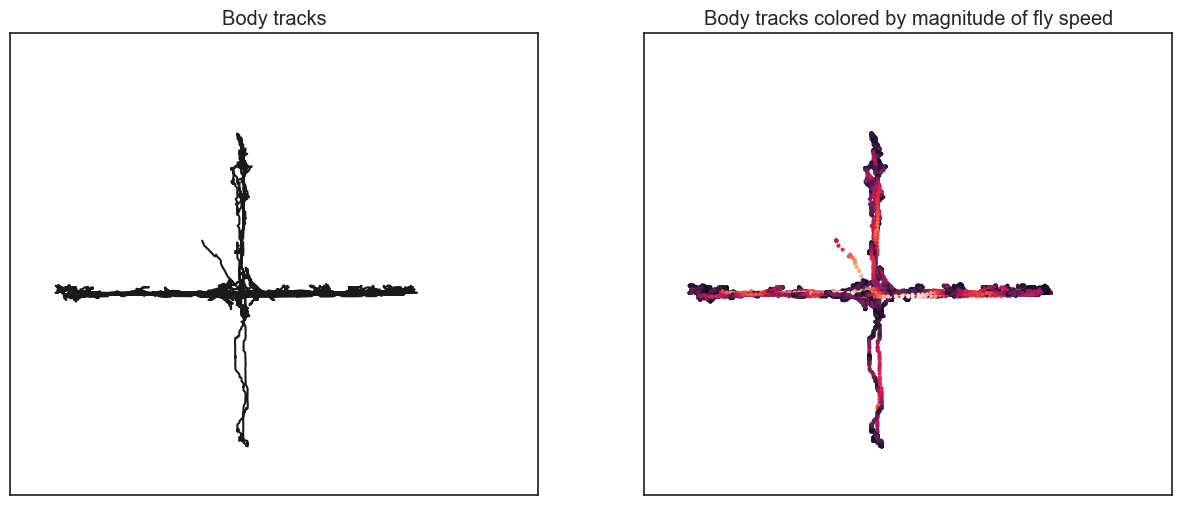

In [40]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(body_loc[:, 0, 0], body_loc[:, 1, 0], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Body tracks')

kp = body_vel
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(body_loc[:,0,0], body_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Body tracks colored by magnitude of fly speed')